# **Stochastic Variational Inference in the TrueSkill Model:**
An approach using Bayesian inference in large models with continuous latent variables and stochastic variational inference with Markov Chain Monte Carlo

# Context

I will implement a variant of the TrueSkill model, a player ranking system for competitive games originally developed for Halo 2.
It is a generalization of the Elo rating system in Chess. the original 2007 NIPS paper introducing the trueskill paper can be found here:
{http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf}. This assignment is also based on one developed by Carl Rasmussen at Cambridge for his course on probabilistic machine learning:
{http://mlg.eng.cam.ac.uk/teaching/4f13/1920/}

# Model definition

First, we'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior.
The prior over each player's skill is a standard normal distribution, and all player's skills are \emph{a prior} independent.  

### The likelihood.
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(\text{A beat B} | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
There can be more than one game played between a pair of players, and in this case the outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.

### The data.
The data will be an array of game outcomes.
Each row contains a pair of player indices.
The first index in each pair is the winner of the game, the second index is the loser.
If there were $M$ games played, then the array has shape $M \times 2$.

# Model Implementation

### Setup and starter code

In [9]:
using Revise
using Statistics: mean
using StatsFuns: log1pexp
using Zygote
using Test
using Logging

┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1273
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
│   exception = Required dependency FFTW_jll [f5851436-0d7a-5f13-b9de-f02708fd171a] failed to load from a cache file.
└ @ Base loading.jl:1036
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
│   exception = Required dependency CommonSubexpressions [bbf7d656-a473-5ed7-a52c-81e309532950] failed to load from a cache file.
└ @ Base loading.jl:1036
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
│   exception = ErrorException("Invalid input in module list: expected ZygoteRules.")
└ @ Base loading.jl:1036


In [13]:
using Plots

In [17]:
#starter functions
function factorized_gaussian_log_density(mu,logsig,xs)
  """
  mu and logsig either same size as x in batch or same as whole batch
  returns a 1 x batchsize array of likelihoods
  """
  σ = exp.(logsig)
  return sum((-1/2)*log.(2π*σ.^2) .+ -1/2 * ((xs .- mu).^2)./(σ.^2),dims=1)
end

function skillcontour!(f; colour=nothing)
  n = 100
  x = range(-3,stop=3,length=n)
  y = range(-3,stop=3,length=n)
  z_grid = Iterators.product(x,y) # meshgrid for contour
  z_grid = reshape.(collect.(z_grid),:,1) # add single batch dim
  z = f.(z_grid)
  z = getindex.(z,1)'
  max_z = maximum(z)
  levels = [.99, 0.9, 0.8, 0.7,0.6,0.5, 0.4, 0.3, 0.2] .* max_z
  if colour==nothing
  p1 = contour!(x, y, z, fill=false, levels=levels)
  else
  p1 = contour!(x, y, z, fill=false, c=colour,levels=levels,colorbar=false)
  end
  plot!(p1)
end

function plot_line_equal_skill!()
  plot!(range(-3, 3, length=200), range(-3, 3, length=200), label="Equal Skill")
end

plot_line_equal_skill! (generic function with 1 method)

Implement a function $\text{log_prior}$ that computes the log of the prior over all player's skills.
  Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, it returns a $K \times 1$ array, where each row contains a scalar giving the log-prior for that set of skills.

In [11]:
function log_prior(zs)
  mu = 0
  logsig = log(1)
  return factorized_gaussian_log_density(mu, logsig, zs)
end

log_prior (generic function with 1 method)

 Implement a function *$\texttt{logp_a_beats_b}$* that, given a pair of skills $z_a$ and $z_b$
    evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.
    To ensure numerical stability, use the function  $\texttt{log1pexp}$ that computes $\log(1 + \exp(x))$ in a numerically stable way.
    This function is provided by $\texttt{StatsFuns.jl}$ and imported already, and also by Python's numpy.

In [12]:
function logp_a_beats_b(za,zb)
  x = -za + zb
  return -log1pexp.(x)
end

logp_a_beats_b (generic function with 1 method)

Assuming all game outcomes are i.i.d. conditioned on all players' skills, implement a function $\texttt{all_games_log_likelihood}$ that takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives a batch of log-likelihoods for those observations.

  Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, and an $M \times 2$ array of game outcomes, it returns a $K \times 1$ array, where each row contains a scalar giving the log-likelihood of all games for that set of skills.

In [14]:
function all_games_log_likelihood(zs,games)
  # games = transpose(games)
  zs_a = zs[(games)[:,1],:]
  zs_b = zs[(games)[:,2],:]
  likelihoods =  logp_a_beats_b.(zs_a, zs_b)
  return sum(likelihoods, dims = 1)
end

all_games_log_likelihood (generic function with 1 method)

Implement a function $\text(joint\_log\_density)$ which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, \dots, z_N, \text{all game outcomes})$

In [16]:
function joint_log_density(zs,games)
  # games = transpose(games)
  return log_prior(zs) + all_games_log_likelihood(zs,games)
end

joint_log_density (generic function with 1 method)

The following below contains test cases for the above function implemented:

In [18]:
@testset "Test shapes of batches for likelihoods" begin
  B = 15 # number of elements in batch
  N = 4 # Total Number of Players
  test_zs = randn(4,15)
  test_games = [1 2; 3 1; 4 2] # 1 beat 2, 3 beat 1, 4 beat 2
  @test size(test_zs) == (N,B)
  #batch of priors
  @test size(log_prior(test_zs)) == (1,B)
  # loglikelihood of p1 beat p2 for first sample in batch
  @test size(logp_a_beats_b(test_zs[1,1],test_zs[2,1])) == ()
  # loglikelihood of p1 beat p2 broadcasted over whole batch
  @test size(logp_a_beats_b.(test_zs[1,:],test_zs[2,:])) == (B,)
  # batch loglikelihood for evidence
  @test size(all_games_log_likelihood(test_zs,test_games)) == (1,B)
  # batch loglikelihood under joint of evidence and prior
  @test size(joint_log_density(test_zs,test_games)) == (1,B)
end

Test Summary:                          | Pass  Total
Test shapes of batches for likelihoods |    6      6


Test.DefaultTestSet("Test shapes of batches for likelihoods", Any[], 6, false)

# Examining the posterior for only two players and toy data

To get a feel for this model, we'll first consider the case where we only have 2 players, $A$ and $B$.
We'll examine how the prior and likelihood interact when conditioning on different sets of games. 
The function $\texttt{skillcontour!}$ evaluates a provided function on a grid of $z_A$ and $z_B$'s and plots the isocontours of that function. As well there is a function $\texttt{plot_line_equal_skill!}$. The function $\texttt{two_player_toy_games}$ produces toy data for two players, 
I.e. $\texttt{two_player_toy_games(5,3)}$ produces a dataset where player A wins 5 games and player B wins 3 games.

For two players $A$ and $B$, plot the isocontours of the joint prior over their skills.  Also plot the line of equal skill, $z_A = z_B$.

In [19]:
# Convenience function for producing toy games between two players.
two_player_toy_games(p1_wins, p2_wins) = vcat([repeat([1,2]',p1_wins), repeat([2,1]',p2_wins)]...)

two_player_toy_games (generic function with 1 method)

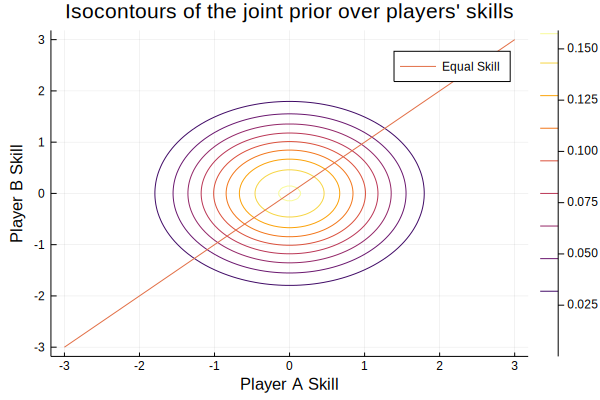

In [21]:
plot(title="Isocontours of the joint prior over players' skills",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
# TODO: plot prior contours
games = two_player_toy_games(5, 3)
joint(zs) = exp(log_prior(zs))
skillcontour!(joint)
plot_line_equal_skill!()

Plot the isocontours of the likelihood function. 
Also plot the line of equal skill, $z_A = z_B$.

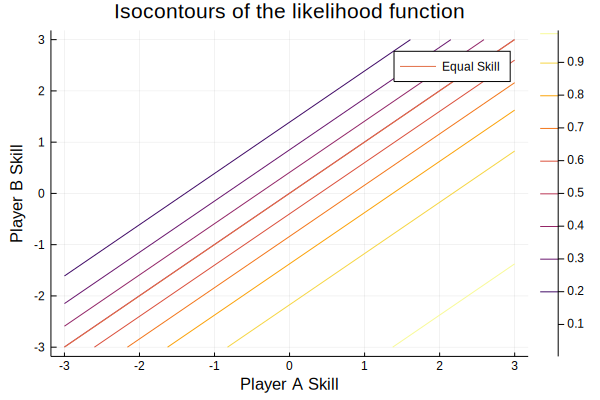

In [22]:
games = two_player_toy_games(1, 0)
plot(title="Isocontours of the likelihood function",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
likeli_(zs) = exp(all_games_log_likelihood(zs, games))
skillcontour!(likeli_)
plot_line_equal_skill!()


Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that player A
beat player B in one match.  Since the contours don't depend on the normalization
constant, we simply plot the isocontours of the log of joint distribution of
$p(z_A, z_B, \text{A beat B})$
Also plot the line of equal skill, $z_A = z_B$.

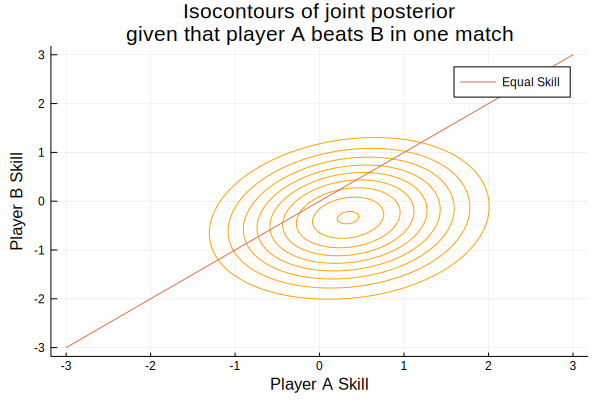

In [23]:
games = two_player_toy_games(1, 0)
plot(title="Isocontours of joint posterior
given that player A beats B in one match",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
joint1(zs) = exp(joint_log_density(zs, games))
skillcontour!(joint1, colour="orange")
plot_line_equal_skill!()

 Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
10 matches were played, and player A beat player B all 10 times.
Also plot the line of equal skill, $z_A = z_B$.

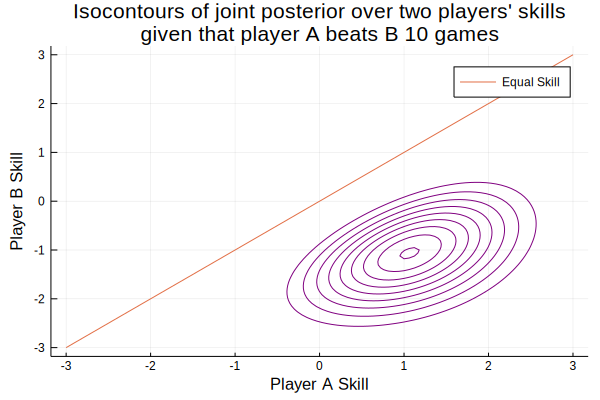

In [24]:
games = two_player_toy_games(10, 0)
plot(title="Isocontours of joint posterior over two players' skills
given that player A beats B 10 games",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
joint2(zs) = exp(joint_log_density(zs, games))
skillcontour!(joint2, colour="purple")
plot_line_equal_skill!()

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
20 matches were played, and each player beat the other 10 times.
Also plot the line of equal skill, $z_A = z_B$.

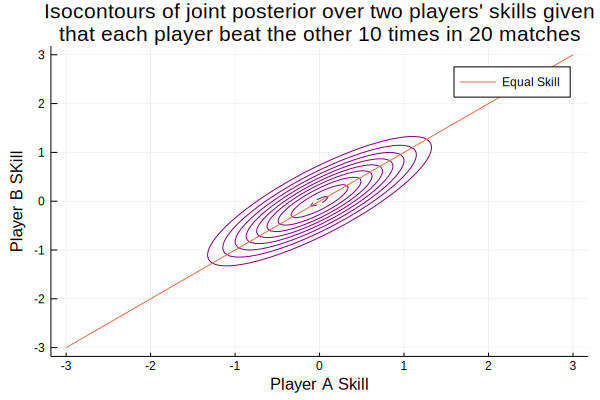

In [27]:
games = two_player_toy_games(10, 10)
#TODO: plot joint contours with player A winning 10 games and player B winning 10 games
plot(title="Isocontours of joint posterior over two players' skills given
that each player beat the other 10 times in 20 matches",
    xlabel = "Player A Skill",
    ylabel = "Player B SKill"
   )
joint3(zs) = exp(joint_log_density(zs, games))
skillcontour!(joint3, colour="purple")
plot_line_equal_skill!()


# Stochastic Variational Inference on Two Players and Toy Data 

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing. Carl Rasmussen's assignment uses Gibbs sampling, a form of **Markov Chain Monte Carlo**.

We'll use gradient-based stochastic variational inference, which wasn't invented until around 2014. 
We will also optimize an approximate posterior distribution with
stochastic variational inference to approximate the true posterior.


Implement a function **elbo** which computes an unbiased estimate of 
    the evidence lower bound.
    The ELBO is equal to the KL divergence between the true posterior $p(z|\text{data})$, and an approximate posterior, $q_\phi(z|\text{data})$, plus an unknown constant.
    Use a fully-factorized Gaussian distribution for $q_\phi(z|\text{data})$.
    This estimator takes the following arguments:
* **params**, the parameters $\phi$ of the approximate posterior $q_\phi(z|\text{data})$.
* A function **logp**, which is equal to the true posterior plus a constant.  This function must take a batch of samples of $z$.  If we have $N$ players, we can consider $B$-many samples from the joint over all players' skills. This batch of samples \texttt{zs} will be an array with dimensions $(N,B)$.
* **num_samples**, the number of samples to take.

This function will return a single scalar, and we will need to use the reparamterization trick when sampling **zs**.

In [29]:
function elbo(params,logp,num_samples)
  num_players = length(params[1])
  mu_vector = params[1] #1xN vector of everyone's mu
  log_sig_vector = params[2]
  sample = exp.(log_sig_vector) .*randn(size(params[1])[1], num_samples) .+ mu_vector
  logp_estimate = logp(sample) #1xbatchsize
  logq_estimate = factorized_gaussian_log_density((mu_vector), (log_sig_vector), sample) #1x batchsize
  return mean(logp_estimate - logq_estimate) # should return scalar (hint: average over batch)
end

elbo (generic function with 1 method)

Write a loss function called **neg\_toy\_elbo** that takes variational distribution parameters and an array of game outcomes, and returns the negative
    elbo estimate with 100 samples.

In [31]:
# Conveinence function for taking gradients
#params is 2xN matrix, N is number of players
function neg_toy_elbo(params; games = two_player_toy_games(1,0), num_samples = 100)
  # TODO: Write a function that takes parameters for q,
  # evidence as an array of game outcomes,
  # and returns the -elbo estimate with num_samples many samples from q
  logp(zs) = joint_log_density(zs,games)
  return -elbo(params,logp, num_samples)
end

neg_toy_elbo (generic function with 1 method)

Write an optimization function **fit\_toy\_variational\_dist**
which takes initial variational parameters, and the evidence.
Inside it will perform a number of iterations of gradient descent where for each iteration :
* Compute the gradient of the loss with respect to the parameters using automatic differentiation.
* Update the parameters by taking an \texttt{lr}-scaled step in the direction of the descending gradient.
* Report the loss with the new parameters (using \texttt{@info} or print statements)
* On the same set of axes plot the target distribution in red and the variational approximation in blue.

Return the parameters resulting from training.

In [32]:
# Toy game
num_players_toy = 2
toy_mu = [0, 0] # Initial mu, can initialize randomly!
toy_ls = [0.5,0.] # Initual log_sigma, can initialize randomly!
toy_params_init = (toy_mu, toy_ls)

function fit_toy_variational_dist(init_params, toy_evidence; num_itrs=200, lr= 1e-2, num_q_samples = 10)
  params_cur = init_params
  for i in 1:num_itrs
    neg_elbo_estimate = neg_toy_elbo(params_cur; games = toy_evidence, num_samples =num_q_samples)
    grad_params = gradient(param_theta -> neg_toy_elbo(param_theta; games= toy_evidence, num_samples= num_q_samples), params_cur)#TODO: gradients of variational objective with respect to parameters
    params_cur = params_cur .- lr .* grad_params[1]  #TODO: update paramters with lr-sized step in descending gradient
    @info  "negative elbo: $(neg_elbo_estimate)" #TODO: report the current elbbo during training
    # TODO: plot true posterior in red and variational in blue
    # hint: call 'display' on final plot to make it display during training
    plot();
    target_posterior(zs) = exp(joint_log_density(zs, toy_evidence))
    skillcontour!(target_posterior,colour=:red) #plot likelihood contours for target posterior
    plot_line_equal_skill!()

    likelihood_countours(zs) =
    # exp(all_games_log_likelihood(zs,toy_evidence))*
    exp(factorized_gaussian_log_density(params_cur[1],params_cur[2],zs))
    display(skillcontour!(likelihood_countours, colour=:blue)) #plot likelihood contours for variational posterior
  end
  return params_cur
end

fit_toy_variational_dist (generic function with 1 method)

Initialize a variational distribution parameters and optimize them to approximate the joint
    where we observe player A winning 1 game.
    Report the final loss.
    Also plot the optimized variational approximation contours (in blue) aand the target distribution (in red) on the same axes.

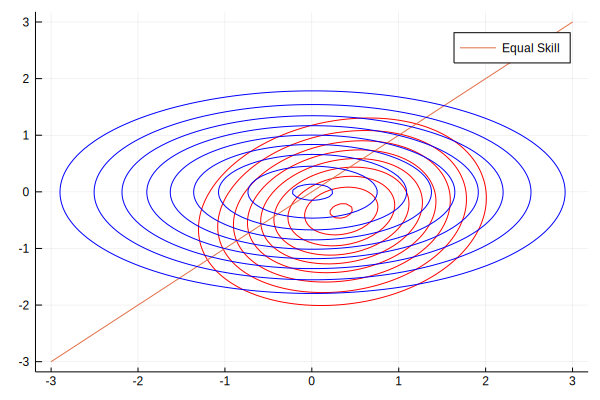

┌ Info: negative elbo: 1.27720643592708
└ @ Main In[32]:13


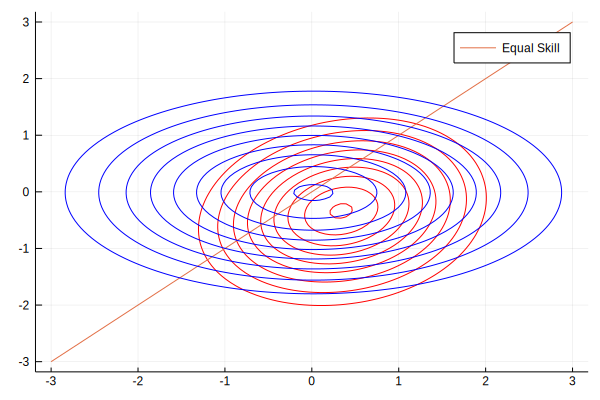

┌ Info: negative elbo: 1.4409279344498003
└ @ Main In[32]:13


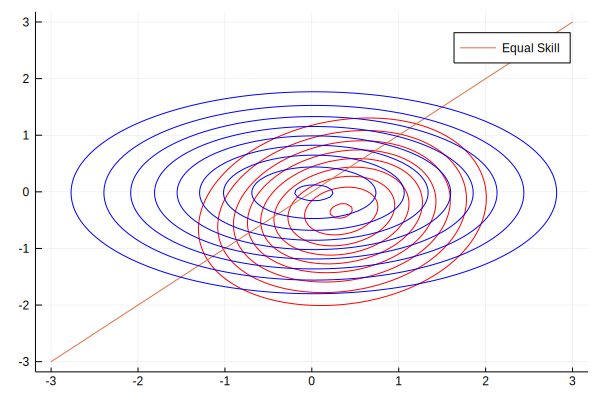

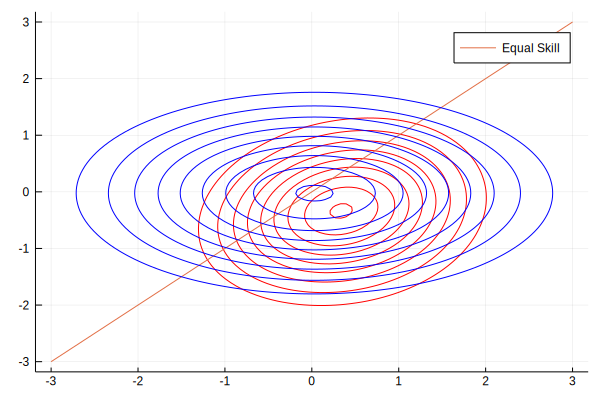

┌ Info: negative elbo: 1.5193613400160626
└ @ Main In[32]:13
┌ Info: negative elbo: 1.3489307000620607
└ @ Main In[32]:13


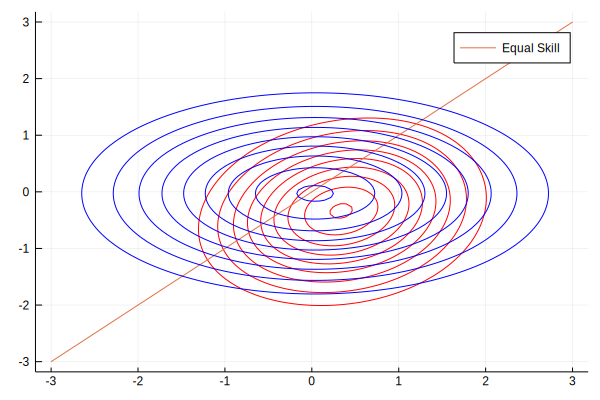

┌ Info: negative elbo: 1.323682628718633
└ @ Main In[32]:13


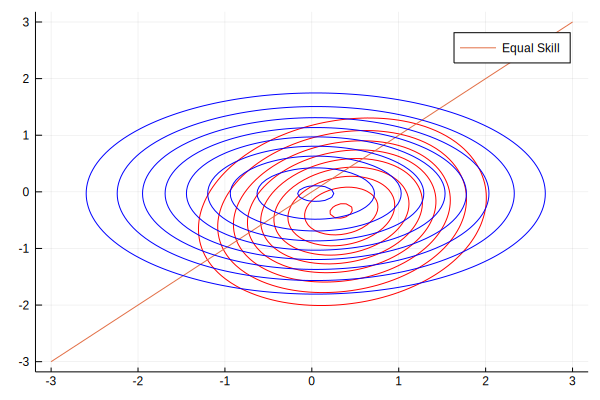

┌ Info: negative elbo: 1.222539530961622
└ @ Main In[32]:13


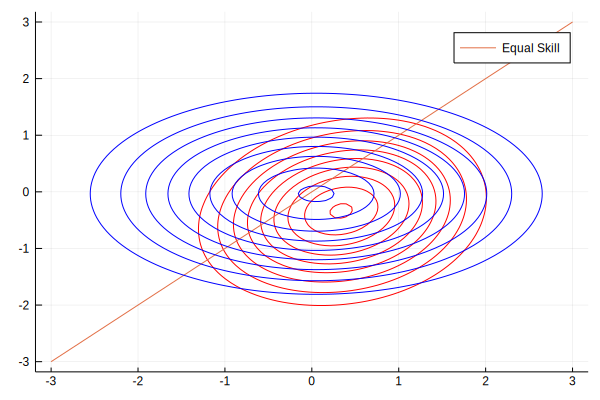

┌ Info: negative elbo: 1.387070442937844
└ @ Main In[32]:13


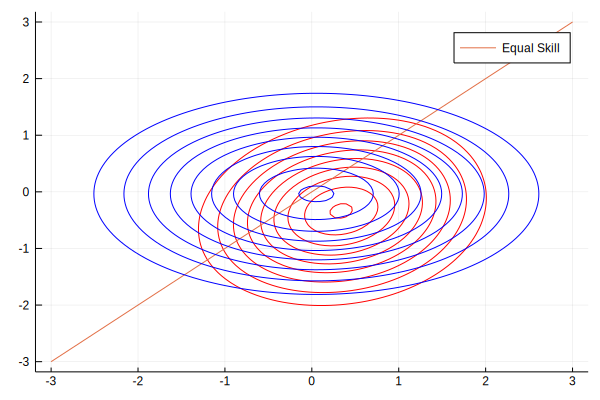

┌ Info: negative elbo: 0.9420229492075094
└ @ Main In[32]:13


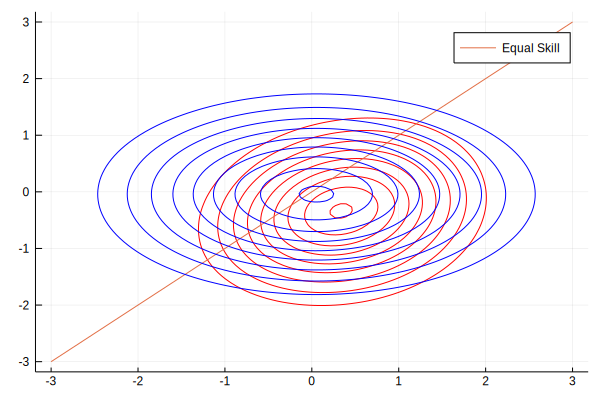

┌ Info: negative elbo: 1.3642347351708557
└ @ Main In[32]:13


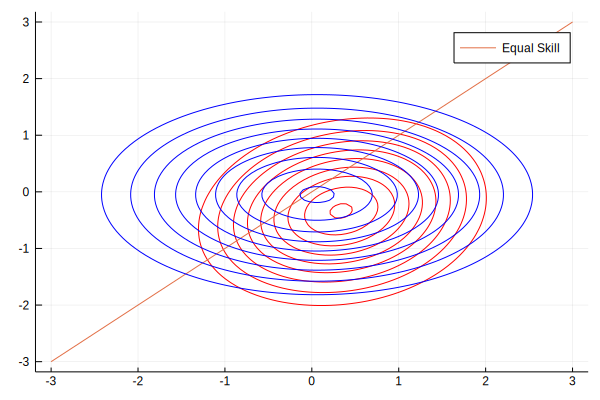

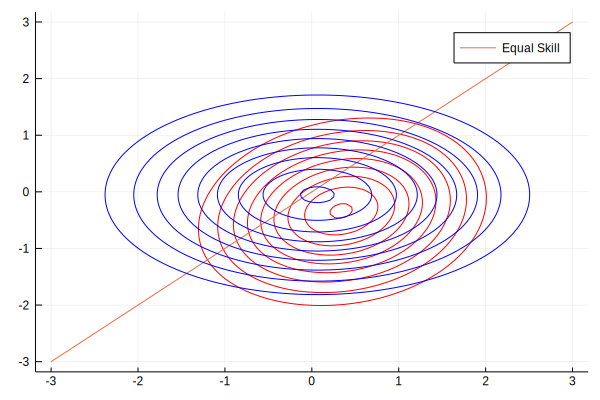

┌ Info: negative elbo: 1.110994219465867
└ @ Main In[32]:13


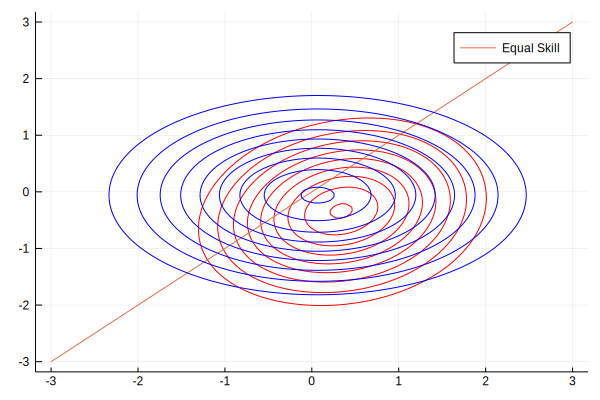

┌ Info: negative elbo: 1.1753025800063686
└ @ Main In[32]:13
┌ Info: negative elbo: 0.869250612952568
└ @ Main In[32]:13


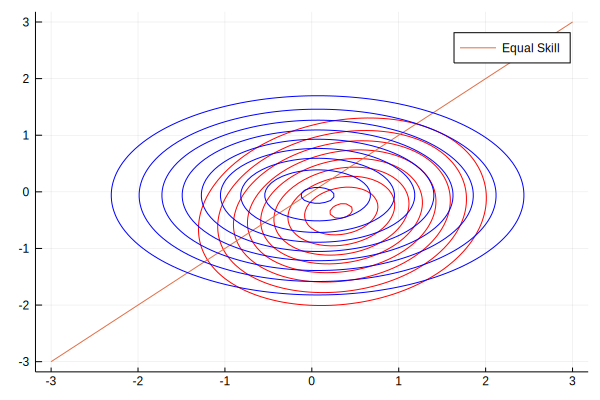

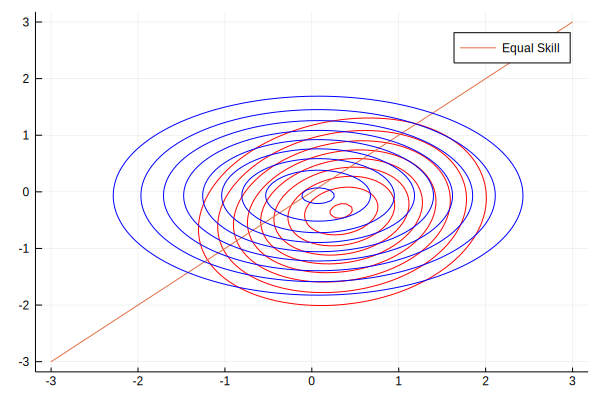

┌ Info: negative elbo: 1.0883148513659544
└ @ Main In[32]:13


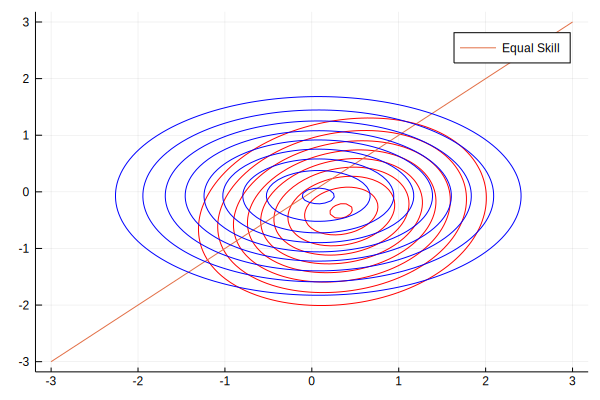

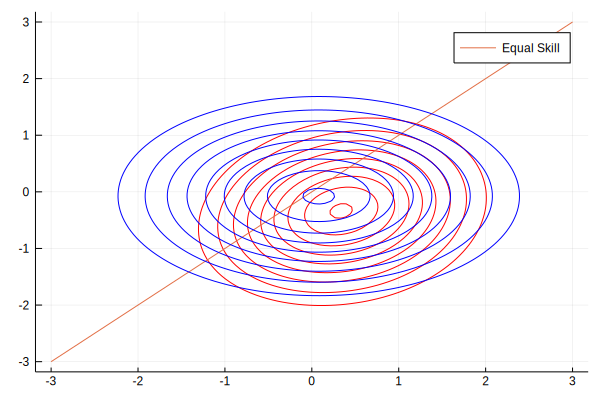

┌ Info: negative elbo: 1.2690653201145599
└ @ Main In[32]:13
┌ Info: negative elbo: 1.1187852152428375
└ @ Main In[32]:13
┌ Info: negative elbo: 1.1519471410234172
└ @ Main In[32]:13


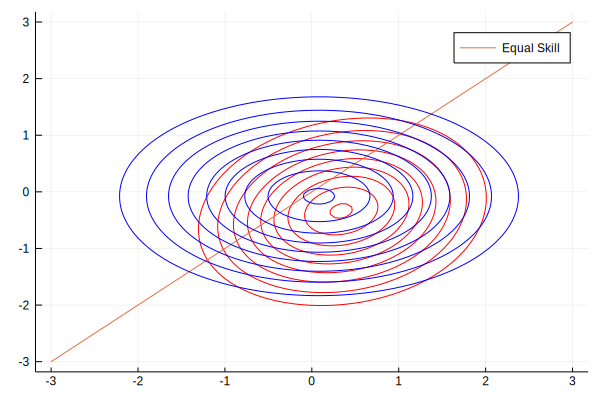

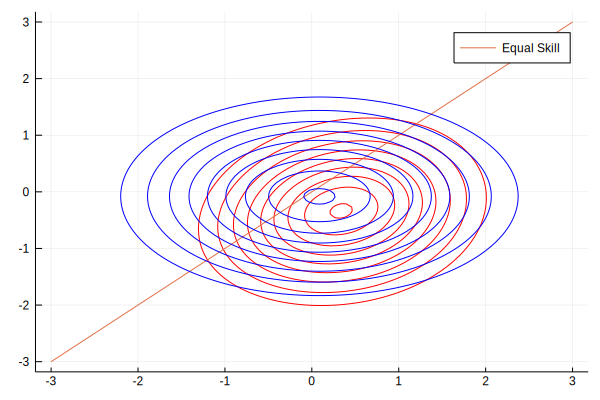

┌ Info: negative elbo: 0.9180750790405804
└ @ Main In[32]:13
┌ Info: negative elbo: 0.9129885359084549
└ @ Main In[32]:13


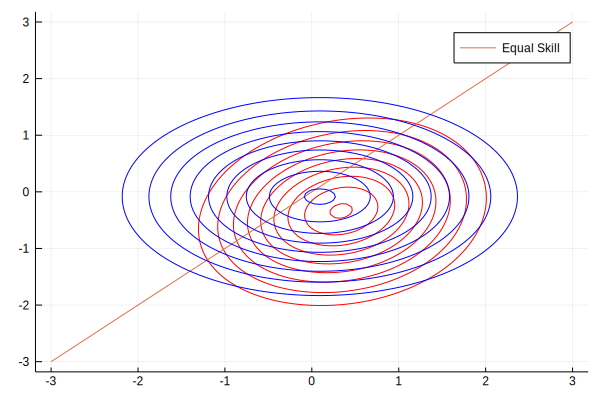

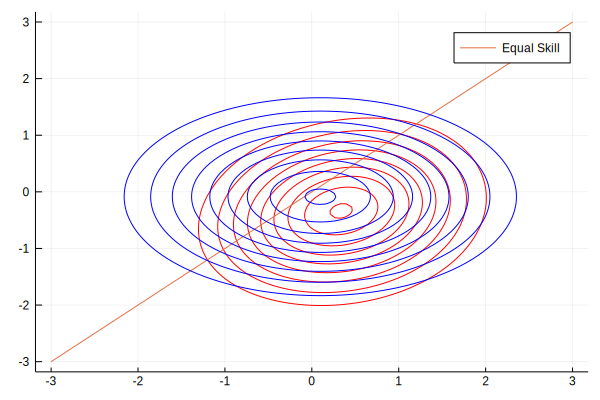

┌ Info: negative elbo: 0.8996881926583264
└ @ Main In[32]:13


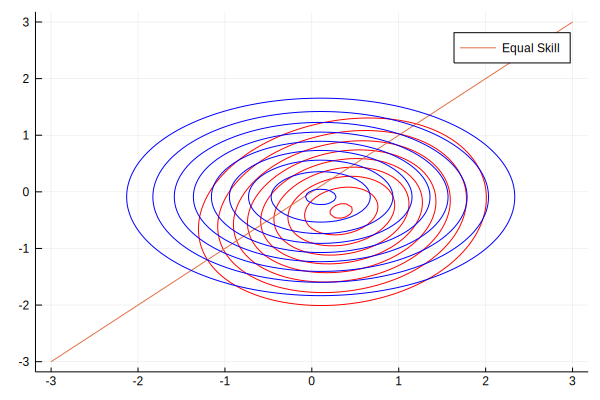

┌ Info: negative elbo: 0.8891737295759589
└ @ Main In[32]:13
┌ Info: negative elbo: 0.973246310709104
└ @ Main In[32]:13


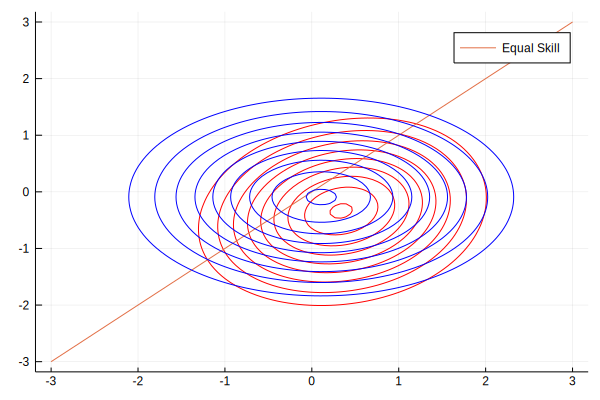

┌ Info: negative elbo: 0.9300857902979266
└ @ Main In[32]:13


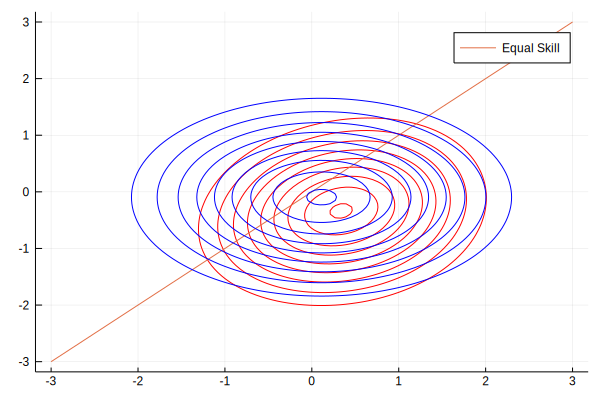

┌ Info: negative elbo: 0.8862262405916665
└ @ Main In[32]:13


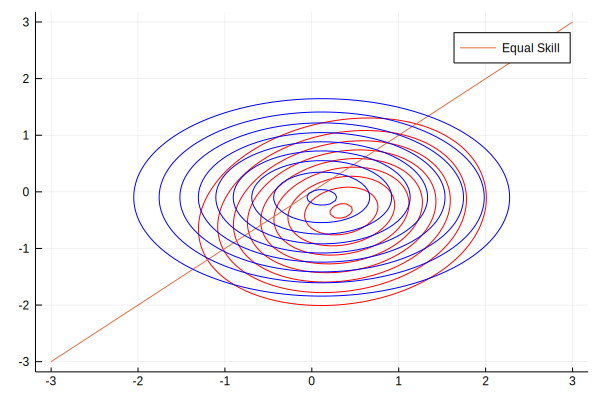

┌ Info: negative elbo: 0.751546641446787
└ @ Main In[32]:13


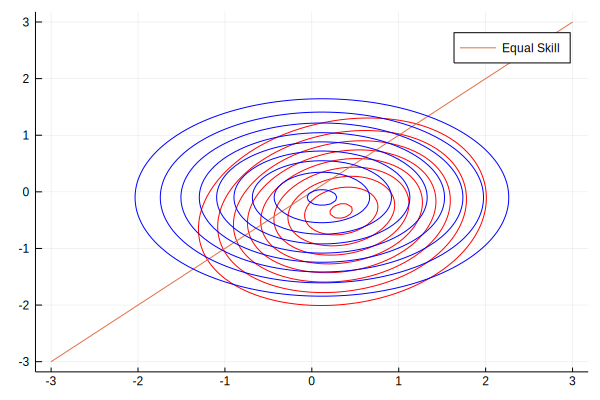

┌ Info: negative elbo: 0.7237175000047157
└ @ Main In[32]:13


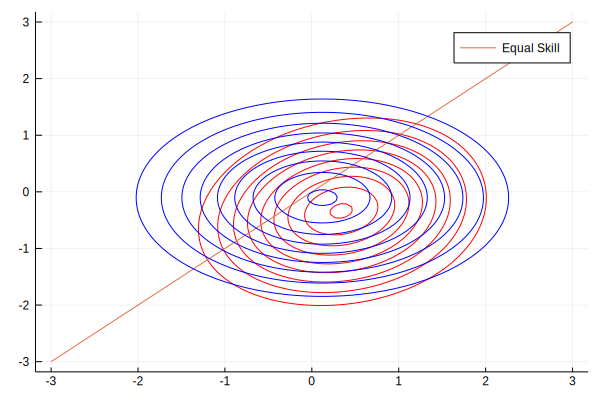

┌ Info: negative elbo: 0.9672980127201347
└ @ Main In[32]:13


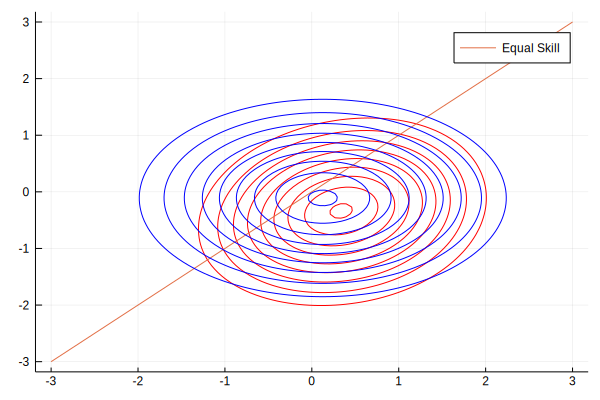

┌ Info: negative elbo: 0.9329892091618069
└ @ Main In[32]:13


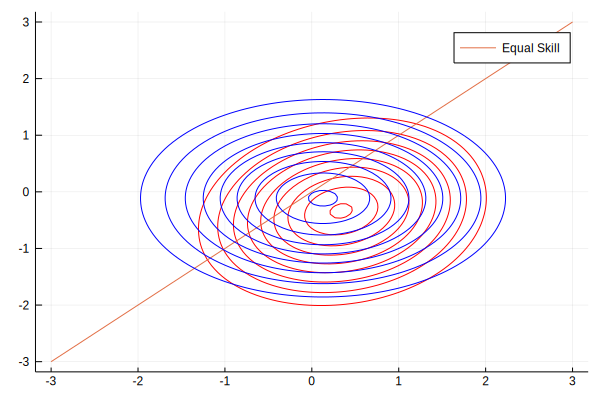

┌ Info: negative elbo: 0.8437515232527548
└ @ Main In[32]:13


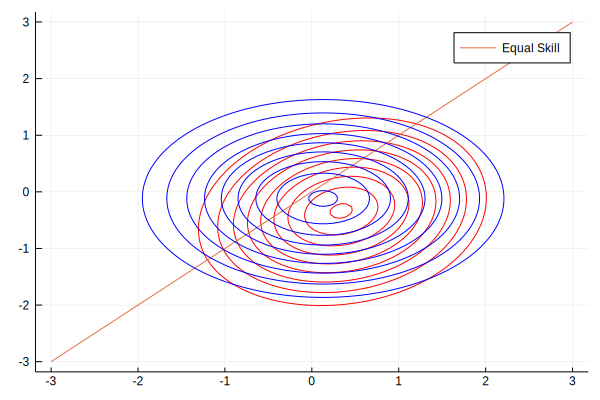

┌ Info: negative elbo: 0.7708874035807162
└ @ Main In[32]:13


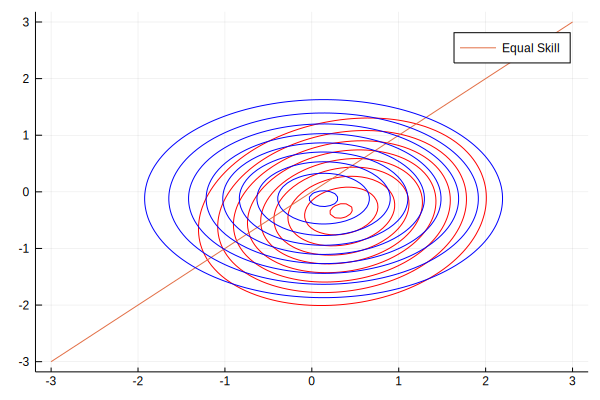

┌ Info: negative elbo: 0.9164238571001394
└ @ Main In[32]:13


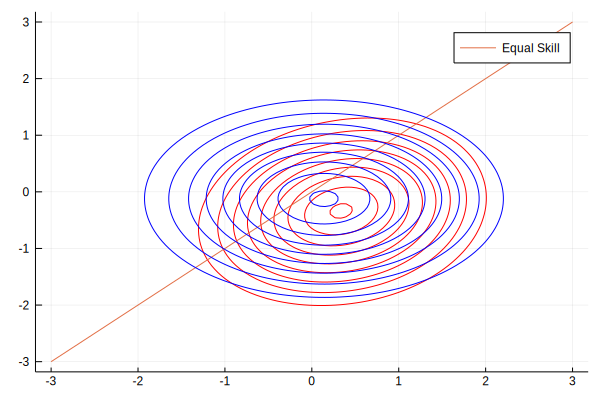

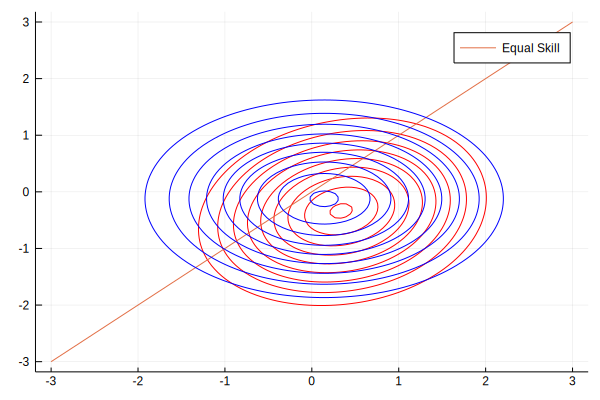

┌ Info: negative elbo: 0.997404026087339
└ @ Main In[32]:13
┌ Info: negative elbo: 0.8402626626714067
└ @ Main In[32]:13


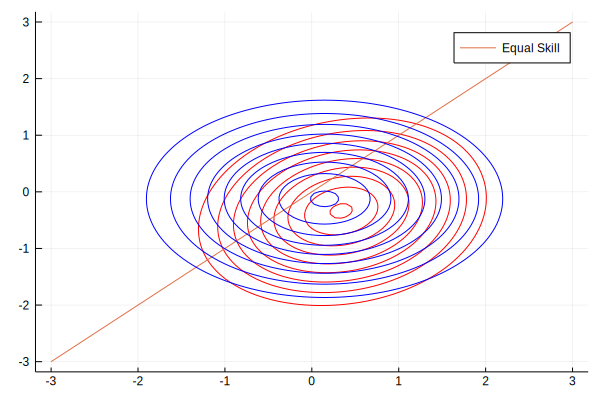

┌ Info: negative elbo: 0.8528001207239443
└ @ Main In[32]:13


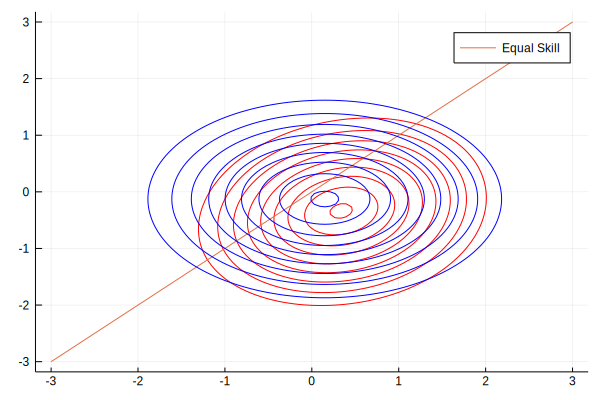

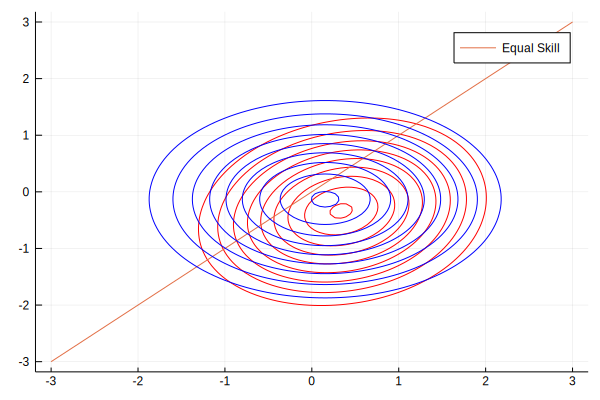

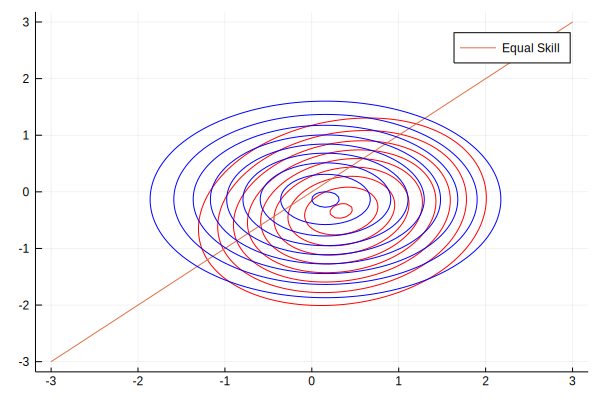

┌ Info: negative elbo: 0.8134833014214807
└ @ Main In[32]:13
┌ Info: negative elbo: 0.8996843694079876
└ @ Main In[32]:13
┌ Info: negative elbo: 0.7951789060407617
└ @ Main In[32]:13


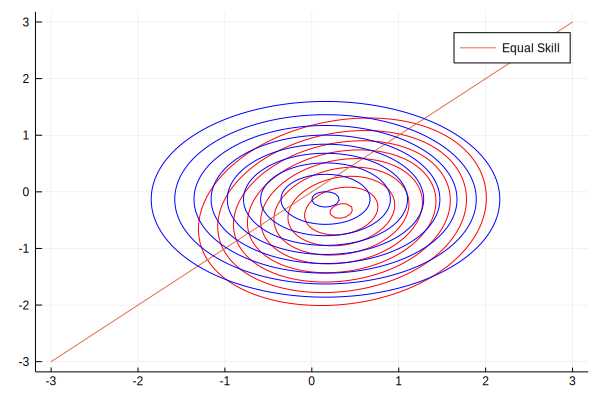

┌ Info: negative elbo: 0.7639711482107506
└ @ Main In[32]:13


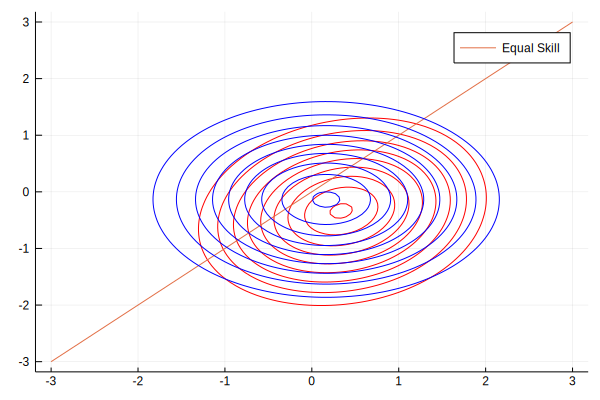

┌ Info: negative elbo: 0.7979437769754364
└ @ Main In[32]:13


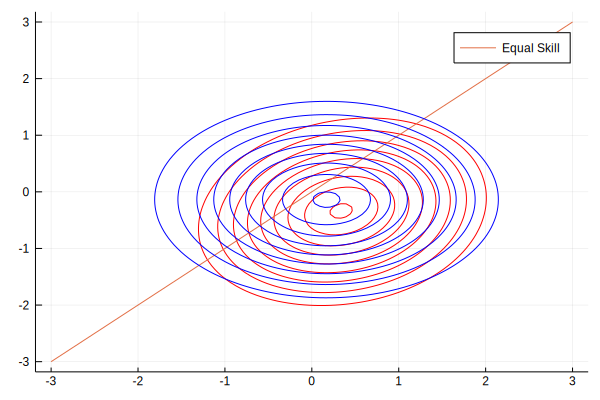

┌ Info: negative elbo: 0.7276610811767159
└ @ Main In[32]:13


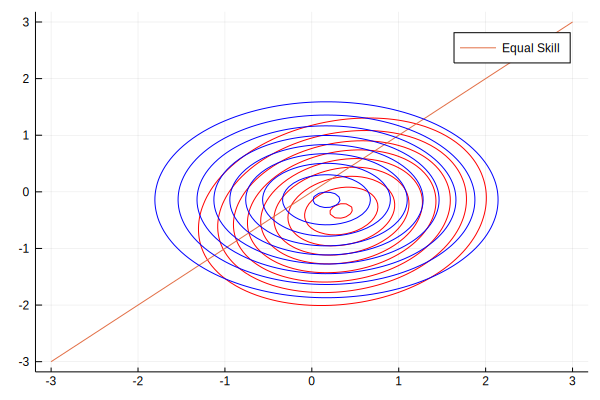

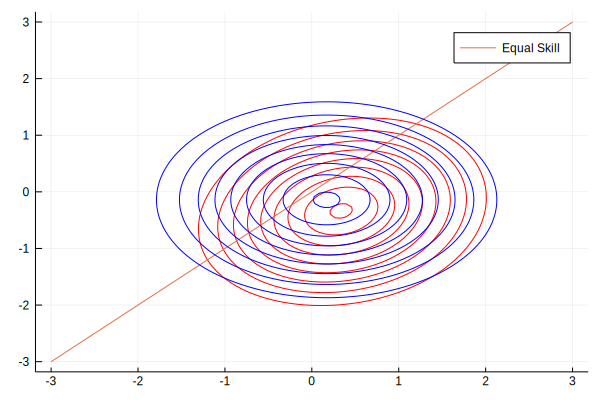

┌ Info: negative elbo: 0.6844243218458843
└ @ Main In[32]:13
┌ Info: negative elbo: 0.6991529038592705
└ @ Main In[32]:13


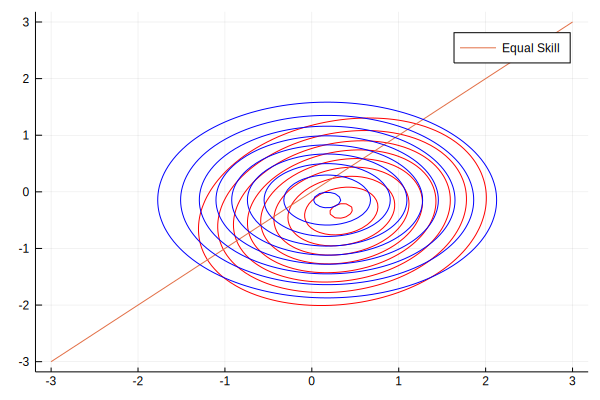

┌ Info: negative elbo: 0.7581970921044036
└ @ Main In[32]:13


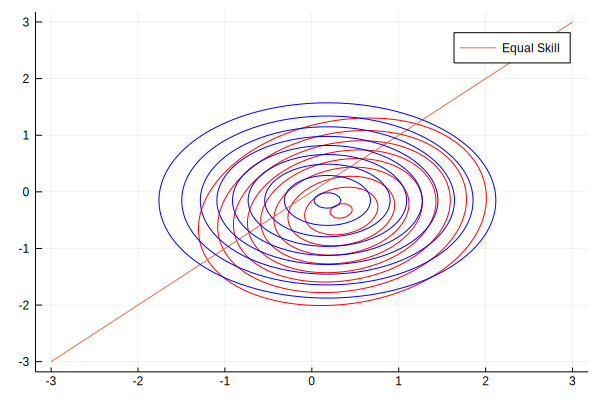

┌ Info: negative elbo: 0.7753664321258579
└ @ Main In[32]:13


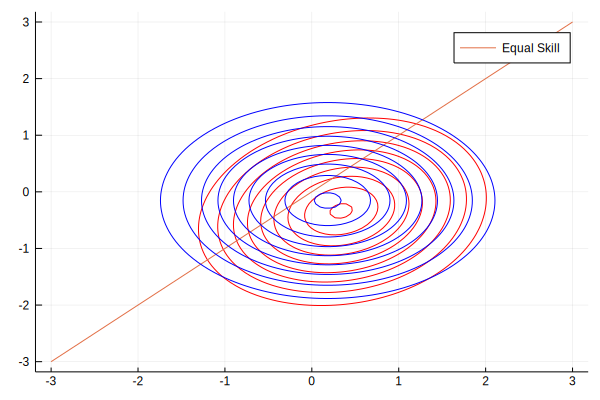

┌ Info: negative elbo: 0.7816105396956192
└ @ Main In[32]:13


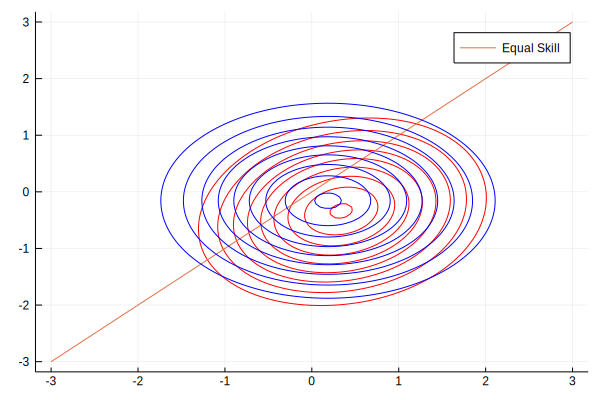

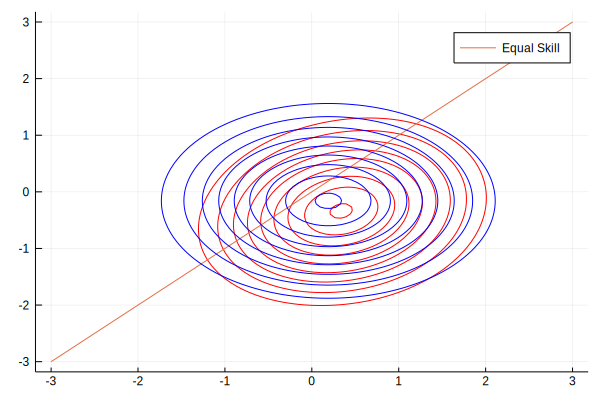

┌ Info: negative elbo: 0.8567043057105239
└ @ Main In[32]:13
┌ Info: negative elbo: 0.8119722444907461
└ @ Main In[32]:13


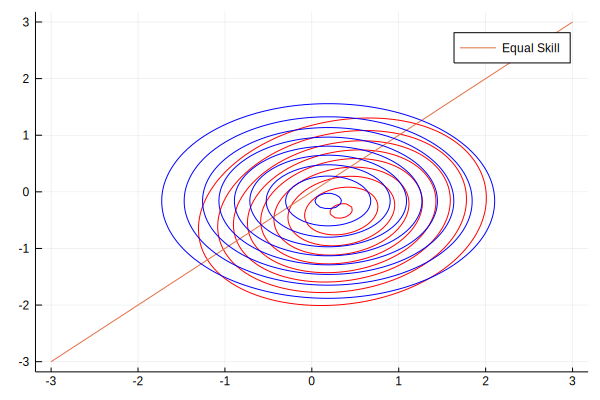

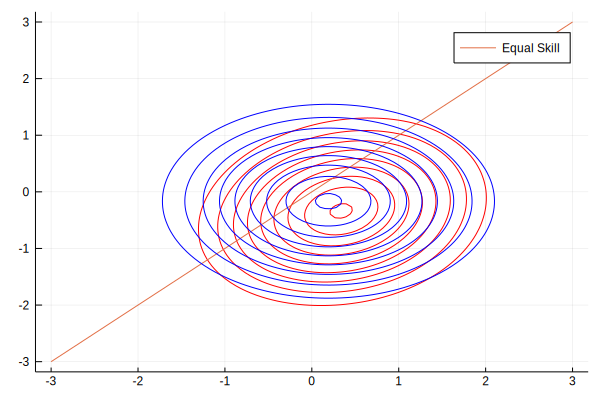

┌ Info: negative elbo: 0.8268482490222475
└ @ Main In[32]:13


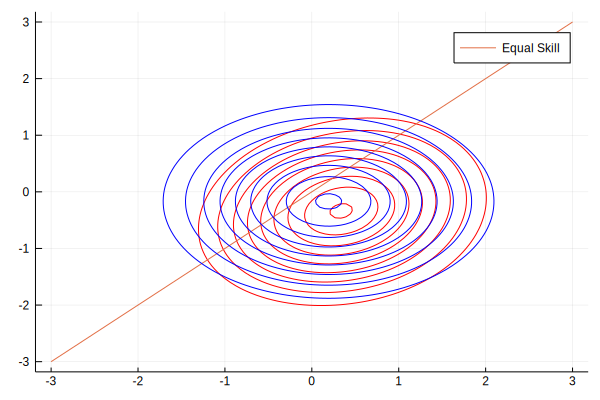

┌ Info: negative elbo: 0.684867731778636
└ @ Main In[32]:13
┌ Info: negative elbo: 0.7140720960927802
└ @ Main In[32]:13


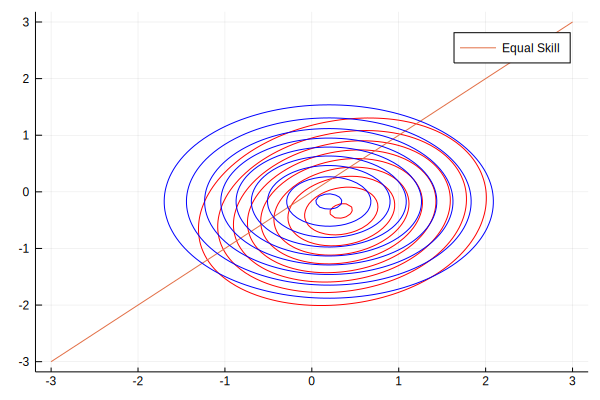

┌ Info: negative elbo: 0.7218000399187409
└ @ Main In[32]:13


([0.1952025174077175, -0.1709861198905889], [0.053821563760588366, -0.04971984132701151])

In [33]:
#fit q with SVI observing player A winning 1 game
games = two_player_toy_games(1, 0)
fit_toy_variational_dist(toy_params_init, games; num_itrs=50, lr= 1e-2, num_q_samples = 50)

# Implementation

# Implementation